In [1]:
import numpy as np
import cv2
import pandas as pd

 

import pickle
from matplotlib import pyplot as plt
import os
from datetime import datetime 

In [2]:
pip install lightgbm

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [4]:
!unzip HAM
DATA_DIR = './HAM/data/HAM/'
# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
 print('Please, upload the data!')

Archive:  HAM.zip
replace HAM/data/HAM/test/ISIC_0024414.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [6]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES 
################################################################
train_images = pd.DataFrame()  #Dataframe to capture image features

for image in sorted(os.listdir(x_train_dir))[:20]: #iterate through each file 
    
    df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
    #Reset dataframe to blank after each loop.

    input_img = cv2.imread(os.path.join(x_train_dir, image))  #Read images
    
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(128,128))

################################################################
#START ADDING DATA TO THE DATAFRAME
        
        
    #Add pixel values to the data frame
    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
    df['Image_Name'] = image   #Capture image name as we read multiple images
    
    
############################################################################    
        #Generate Gabor features
    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    for theta in range(2):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                    gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    num += 1  #Increment for gabor column label
                    
        
########################################
#Gerate OTHER FEATURES and add them to the data frame
                
    #CANNY EDGE
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1 #Add column to original dataframe
    
    from skimage.filters import roberts, sobel, scharr, prewitt
    
    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1
    
    #SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1
    
    #SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1
    
    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1
    
    #GAUSSIAN with sigma=3
    from scipy import ndimage as nd
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1
    
    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3
    
    #MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    
    #VARIANCE with size=3
#    variance_img = nd.generic_filter(img, np.var, size=3)
#    variance_img1 = variance_img.reshape(-1)
#    df['Variance s3'] = variance_img1  #Add column to original dataframe


######################################                    
#Update dataframe for images to include details for each image in the loop
    train_images = train_images.append(df)

In [7]:
###########################################################
# STEP 2: READ LABELED IMAGES (MASKS) AND CREATE ANOTHER DATAFRAME
    # WITH LABEL VALUES AND LABEL FILE NAMES
##########################################################
train_masks = pd.DataFrame()  #Create dataframe to capture mask info.

for mask in sorted(os.listdir(y_train_dir))[:20]:   #iterate through each file to perform some action
    
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = cv2.imread(os.path.join(y_train_dir, mask), cv2.IMREAD_GRAYSCALE)
    input_mask=cv2.resize(input_mask,(128,128))
    ret, input_mask = cv2.threshold(input_mask, 127, 1, cv2.THRESH_BINARY) 
      
    label = input_mask

    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    
    train_masks = train_masks.append(df2)  #Update mask dataframe with all the info from each mask


In [8]:
################################################################
 #  STEP 3: GET DATA READY FOR RANDOM FOREST (or other classifier)
    # COMBINE BOTH DATAFRAMES INTO A SINGLE DATASET
###############################################################
dataset = pd.concat([train_images, train_masks], axis=1)    #Concatenate both image and mask datasets

#Assign training features to X and labels to Y
#Drop columns that are not relevant for training (non-features)
X_train = dataset.drop(labels = ["Image_Name", "Mask_Name", "Label_Value"], axis=1) 

#Assign label values to Y (our prediction)
Y_train = dataset["Label_Value"].values 

#Encode Y values to 0, 1, 2, 3, .... (NOt necessary but makes it easy to use other tools like ROC plots)
from sklearn.preprocessing import LabelEncoder
Y_train = LabelEncoder().fit_transform(Y_train)

In [9]:
####################################################################
# STEP 4: Define the classifier and fit a model with our training data
###################################################################

import lightgbm as lgb

d_train = lgb.Dataset(X_train, Y_train)
## Train the model on training data
lgbm_params = {'objective':'binary', 'max_depth':20}

start = datetime.now() 
model = lgb.train(lgbm_params, d_train, 100) #50 iterations. Increase iterations for small learning rates
stop = datetime.now()

execution_time = stop-start
print("execution time is: ", execution_time)

execution time is:  0:00:05.505607


In [10]:
####################################################################
## STEP 5:   PERFORM STEP 1, STEP 2 AND STEP 3 FOR TESTING DATA
################################################################
test_images = pd.DataFrame()  #Dataframe to capture image features

for image in sorted(os.listdir(x_test_dir))[:10]: #iterate through each file 
    
    df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
    #Reset dataframe to blank after each loop.

    input_img = cv2.imread(os.path.join(x_test_dir, image))  #Read images
    
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(128,128))

################################################################
#START ADDING DATA TO THE DATAFRAME
        
        
    #Add pixel values to the data frame
    pixel_values = img.reshape(-1)
    df['Pixel_Value'] = pixel_values   #Pixel value itself as a feature
    df['Image_Name'] = image   #Capture image name as we read multiple images
    
    
############################################################################    
        #Generate Gabor features
    num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
    kernels = []
    for theta in range(2):   #Define number of thetas
        theta = theta / 4. * np.pi
        for sigma in (1, 3):  #Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi / 4):   #Range of wavelengths
                for gamma in (0.05, 0.5):   #Gamma values of 0.05 and 0.5
                    gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
                    ksize=9
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                    kernels.append(kernel)
                    #Now filter the image and add values to a new column 
                    fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
                    num += 1  #Increment for gabor column label
                    
        
########################################
#Gerate OTHER FEATURES and add them to the data frame
                
    #CANNY EDGE
    edges = cv2.Canny(img, 100,200)   #Image, min and max values
    edges1 = edges.reshape(-1)
    df['Canny Edge'] = edges1 #Add column to original dataframe
    
    from skimage.filters import roberts, sobel, scharr, prewitt
    
    #ROBERTS EDGE
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1
    
    #SOBEL
    edge_sobel = sobel(img)
    edge_sobel1 = edge_sobel.reshape(-1)
    df['Sobel'] = edge_sobel1
    
    #SCHARR
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1
    
    #PREWITT
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1
    
    #GAUSSIAN with sigma=3
    from scipy import ndimage as nd
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian_img1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian_img1
    
    #GAUSSIAN with sigma=7
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian_img3 = gaussian_img2.reshape(-1)
    df['Gaussian s7'] = gaussian_img3
    
    #MEDIAN with sigma=3
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    
    #VARIANCE with size=3
#    variance_img = nd.generic_filter(img, np.var, size=3)
#    variance_img1 = variance_img.reshape(-1)
#    df['Variance s3'] = variance_img1  #Add column to original dataframe


######################################                    
#Update dataframe for images to include details for each image in the loop
    test_images = test_images.append(df)
#######################################
test_masks = pd.DataFrame()  #Create dataframe to capture mask info.

for mask in sorted(os.listdir(y_test_dir))[:10]:  #iterate through each file to perform some action
    
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = cv2.imread(os.path.join(y_test_dir, mask), cv2.IMREAD_GRAYSCALE)
    input_mask=cv2.resize(input_mask,(128,128))
    ret, input_mask = cv2.threshold(input_mask, 127, 1, cv2.THRESH_BINARY) 
    
    label = input_mask
    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    
    test_masks = test_masks.append(df2)  #Update mask dataframe with all the info from each mask

###############################################################
test_dataset = pd.concat([test_images, test_masks], axis=1)    #Concatenate both image and mask datasets

#Assign training features to X and labels to Y
#Drop columns that are not relevant for training (non-features)
X_test = test_dataset.drop(labels = ["Image_Name", "Mask_Name", "Label_Value"], axis=1) 

#Assign label values to Y (our prediction)
Y_test = test_dataset["Label_Value"].values 

#Encode Y values to 0, 1, 2, 3, .... (NOt necessary but makes it easy to use other tools like ROC plots)
from sklearn.preprocessing import LabelEncoder
Y_test = LabelEncoder().fit_transform(Y_test)

In [11]:
####################################################################
## STEP 6:   CHECK IOU SCORE
################################################################
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=2)  

test_prediction = model.predict(X_test)
test_prediction[test_prediction < 0.5] = 0
test_prediction[test_prediction >= 0.5] = 1

IOU_keras.update_state(Y_test, test_prediction)
print ("IOU on testing data = ", IOU_keras.result().numpy())

print ("IOU for each class on testing data:")
values = np.array(IOU_keras.get_weights()).reshape(2,2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]+ values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0]+ values[0,1])
print(class1_IoU)
print(class2_IoU)

train_prediction = model.predict(X_train)
train_prediction[train_prediction < 0.5] = 0
train_prediction[train_prediction >= 0.5] = 1

IOU_keras.update_state(Y_train, train_prediction)
print ("IOU on training data = ", IOU_keras.result().numpy())

print ("IOU for each class on training data:")
values = np.array(IOU_keras.get_weights()).reshape(2,2)
class1_IoU = values[0,0]/(values[0,0] + values[0,1]+ values[1,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0]+ values[0,1])
print(class1_IoU)
print(class2_IoU)

IOU on testing data =  0.7621087
IOU for each class on testing data:
0.8899395983398629
0.6342777093447335
IOU on training data =  0.7613721
IOU for each class on training data:
0.87620922567139
0.6465349567893758


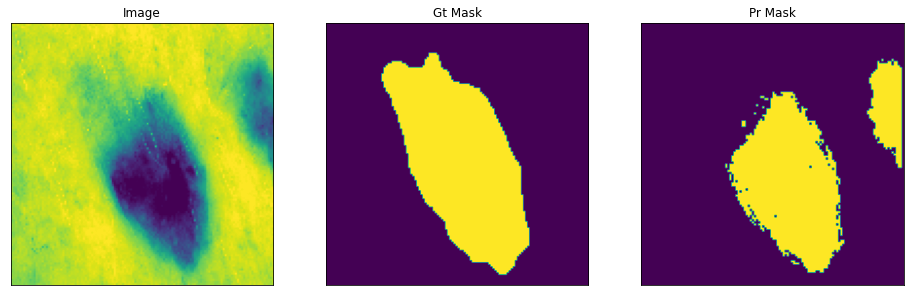

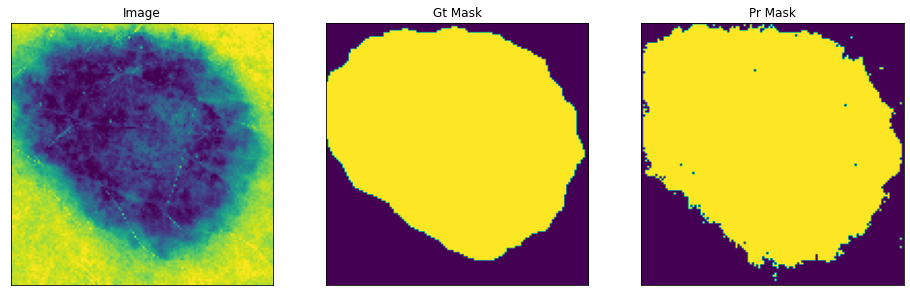

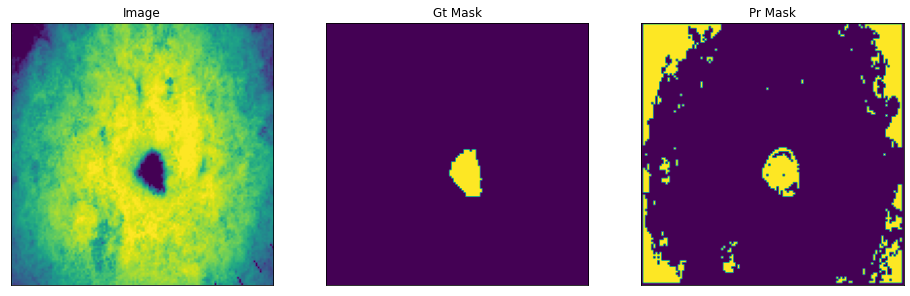

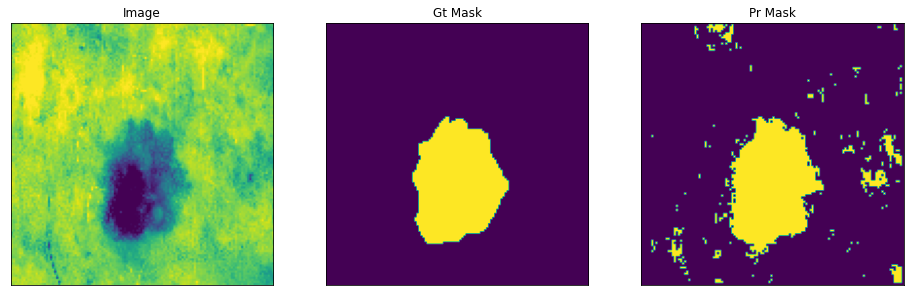

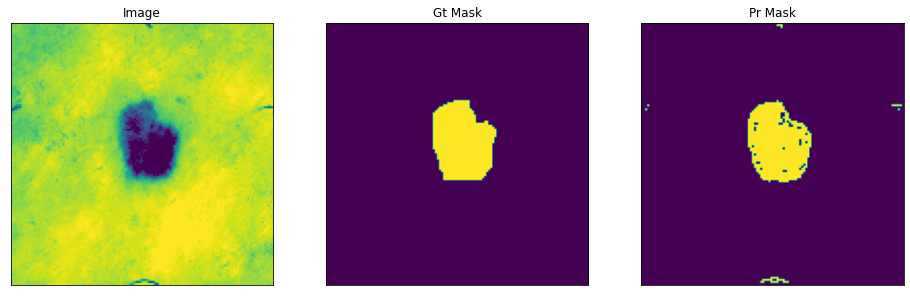

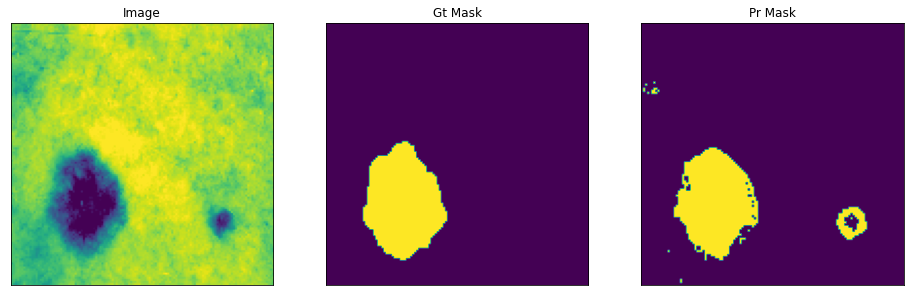

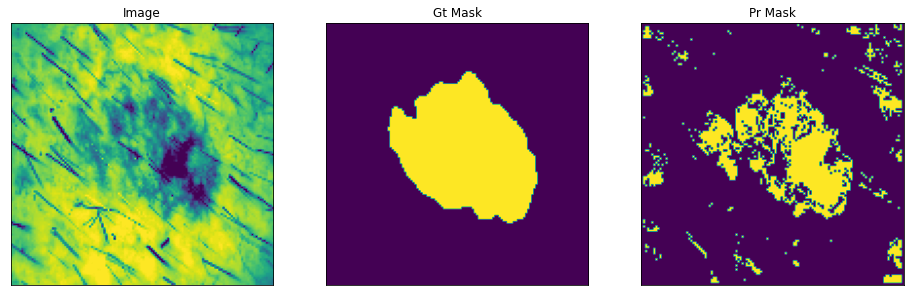

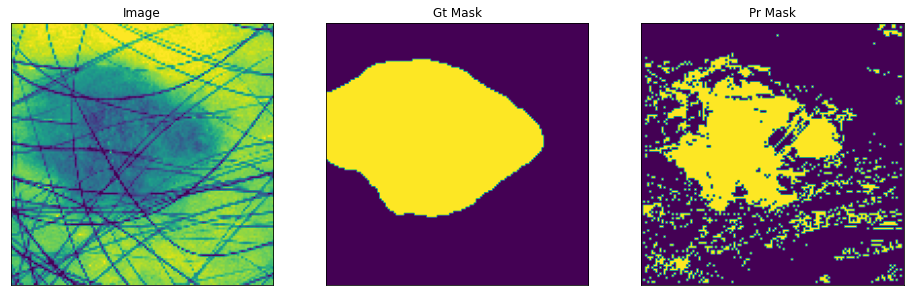

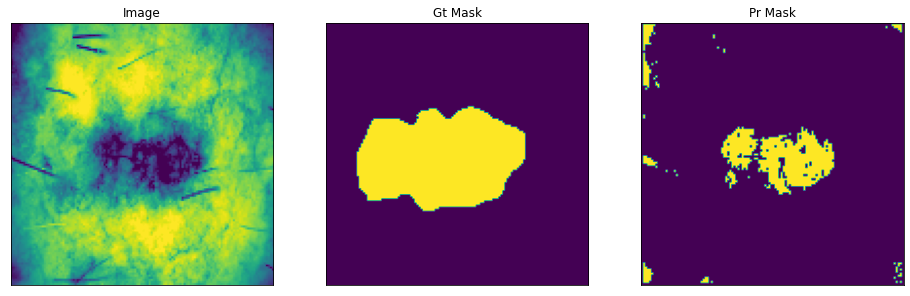

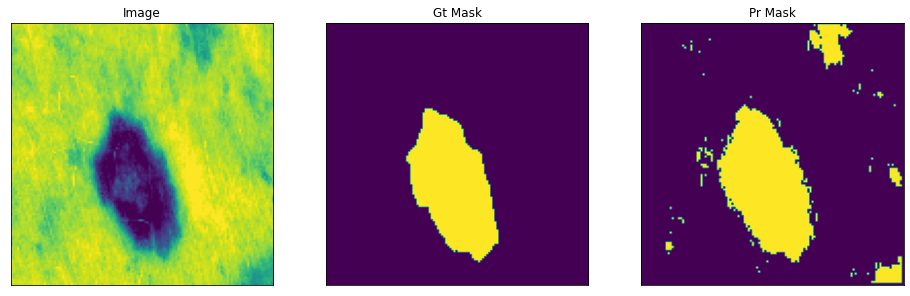

In [12]:
for df in test_dataset.groupby('Image_Name'):
    image = df[1].drop(labels = ["Image_Name", "Mask_Name", "Label_Value"], axis=1) 
    pr_mask = model.predict(image)

    pr_mask[pr_mask < 0.5] = 0
    pr_mask[pr_mask >= 0.5] = 1
    
    gt_mask=df[1]['Label_Value'].values.reshape((128,128))
    image=df[1]['Pixel_Value']
    image=image.values.reshape((128,128))
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.reshape(gt_mask.shape).squeeze(),
    )